In [143]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [120]:
train_samples = pd.read_csv("Train_data.csv")
test_samples = pd.read_csv("Test_data.csv")

train_samples.head() # check first few columns of the train set.

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [121]:
'''
Preprocessing:

By looking at the data we can see that it contains lots of words like ('@user'), punctuation and special characters.

These are not gonna help us in analysis.So its better to remove them to get best analysis.

We are going to do 4 types of preprocessing on this data:

1) Removing @user 
2) Remove punctuations,special characters and numbers
3) Remove short words like on,at,is,him.. Typically words of length < 4
4) Stemming of words. Replacing a word with its root word is stemming. 
Words like singing, singer, sang are different forms of the word sing. Stemming replaces singing, singer, sang with a single word sing.

'''

# Combine the train and test to apply the cleansing to the data at once. 

combine = train_samples.append(test_samples,ignore_index=True,sort=False)

# Remove @user

def remove(input_text, pattern):
    
    x=re.findall(pattern,input_text)
    
    for p in x:
        input_text = re.sub(p,'',input_text)
    
    return input_text

combine['preprocessed_tweet'] = np.vectorize(remove)(combine['tweet'],"@[\w]*")


In [122]:
# Remove punctuations, numbers and special characters


combine['preprocessed_tweet'] = combine['preprocessed_tweet'].replace("[^a-zA-Z#]"," ")

In [123]:
# Remove words of length lesser than 4

combine['preprocessed_tweet'] = combine['preprocessed_tweet'].apply(lambda x : ' '.join([word for word in x.split() if len(word)>3]))

In [124]:
# Stemming

tweet_tokens = combine['preprocessed_tweet'].apply(lambda x: x.split()) 

tweet_tokens.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, can't, cause, they, do...
2                              [bihday, your, majesty]
3    [#model, love, take, with, time, urð±!!!, ð...
4                  [factsguide:, society, #motivation]
Name: preprocessed_tweet, dtype: object

In [125]:
stemmer = PorterStemmer()

tweet_tokens = tweet_tokens.apply(lambda x : [stemmer.stem(i) for i in x])
tweet_tokens.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, can't, caus, they, don'...
2                              [bihday, your, majesti]
3    [#model, love, take, with, time, urð±!!!, ð...
4                       [factsguide:, societi, #motiv]
Name: preprocessed_tweet, dtype: object

In [126]:
for i in range(len(tweet_tokens)):

    tweet_tokens[i] = ' '.join(tweet_tokens[i])

combine['preprocessed_tweet'] = tweet_tokens

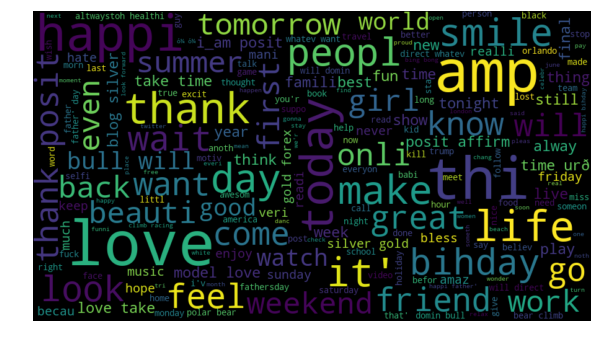

In [127]:
# Visualizing Data using Wordcloud

AllWords = ' '.join([w for w in combine['preprocessed_tweet']])

from wordcloud import WordCloud

wordcloud = WordCloud(width = 900, height = 500, random_state= 21,max_font_size = 100).generate(AllWords)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()


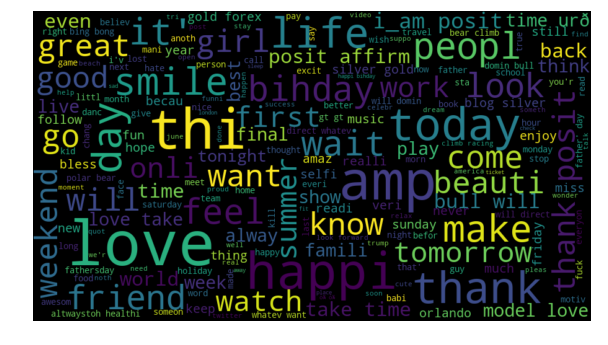

In [128]:
# Visualizing positive or love words
 
positive_words =' '.join([w for w in combine['preprocessed_tweet'] [combine['label'] == 0]] )


wordcloud = WordCloud(width = 900, height = 500, random_state= 21,max_font_size = 100).generate(positive_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

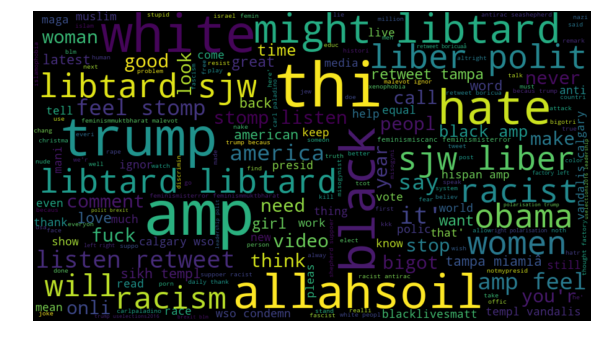

In [129]:
# Visualizing negative or hate words
negative_words =' '.join([w for w in combine['preprocessed_tweet'] [combine['label'] == 1]] )


wordcloud = WordCloud(width = 900, height = 500, random_state= 21,max_font_size = 100).generate(negative_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [130]:
def hashtag(input):
    result =[]
    
    for x in input:
        h= re.findall(r"#(\w+)",x)
        result.append(h)
    return result

In [131]:

# getting all positive Hashtags
positive_hashtag = hashtag(combine['preprocessed_tweet'][combine['label'] == 0])

# getting all negative Hashtags
negative_hashtag = hashtag(combine['preprocessed_tweet'][combine['label'] == 1])


positive_hashtag = sum(positive_hashtag,[]) 

negative_hashtag = sum(negative_hashtag,[])



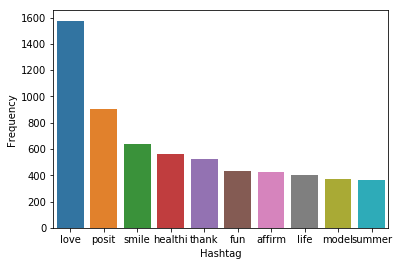

<Figure size 1296x720 with 0 Axes>

In [132]:
# Let try to visualize the most frequently used positive hashtags

fp = nltk.FreqDist(positive_hashtag)

dframe = pd.DataFrame({'Hashtag': list(fp.keys()), 
                       'Occurance': list(fp.values())})

# sekecting the top 10 most frequent words
dframe = dframe.nlargest(columns ="Occurance",n=10)

ax=sns.barplot(data=dframe,x='Hashtag',y='Occurance')

plt.figure(figsize=(18,10))

ax.set(xlabel = "Hashtag")
ax.set(ylabel = "Frequency")

plt.show()

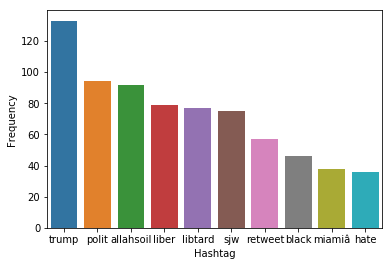

<Figure size 1296x720 with 0 Axes>

In [133]:
# Similarly lets also try to visualize the most frequently used negative hashtags
fn = nltk.FreqDist(negative_hashtag)

dframe = pd.DataFrame({'Hashtag': list(fn.keys()), 
                       'Occurance': list(fn.values())})

# sekecting the top 10 most frequent words
dframe = dframe.nlargest(columns ="Occurance",n=10)

ax=sns.barplot(data=dframe,x='Hashtag',y='Occurance')

plt.figure(figsize=(18,10))

ax.set(xlabel = "Hashtag")
ax.set(ylabel = "Frequency")

plt.show()

In [147]:
# Feature Extraction using CountVectorizer 

vectorizer = CountVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words="english")

vect = vectorizer.fit_transform(combine['preprocessed_tweet'])


In [148]:
# Apply Logistic Regression on vectorized data

X = vect[:31962,:]

X_test = vect[31962:,:]

X_train, X_valid, y_train, y_valid = train_test_split(X, train_samples['label'], random_state=42, test_size=0.3)

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

validation_pred = rfc.predict_proba(X_valid) 

pred = validation_pred[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 then 1 else 0
pred = pred.astype(np.int)

print ("F1 Score:",f1_score(y_valid,pred))


F1 Score: 0.46778559826746074


In [149]:
# Predict on test data

test_pred = rfc.predict_proba(test)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

y_test = test_pred_int

y_pred= rfc.predict(test)

print('Test_Accuracy: %.2f' %accuracy_score(y_test, y_pred))

Test_Accuracy: 0.95


In [150]:
# Feature Extraction using TF-IDF 

tf_vect = TfidfVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words="english")

tfidf= tf_vect.fit_transform(combine['preprocessed_tweet'])

In [151]:
# Apply Logistic Regression on vectorized data

X = tfidf[:31962,:]

X_test = tfidf[31962:,:]

X_train, X_valid, y_train, y_valid = train_test_split(X, train_samples['label'], random_state=42, test_size=0.3)

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

pred = rfc.predict_proba(X_valid) 

pred_int = pred[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 then 1 else 0
pred_int = pred_int.astype(np.int)

print("F1 Score:",f1_score(y_valid,pred_int))


F1 Score: 0.519298245614035


In [152]:
# Predict on test data

test_pred = rfc.predict_proba(test)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

y_test= test_pred_int

y_pred= rfc.predict(test)

print('Test_Accuracy: %.2f' %accuracy_score(y_test, y_pred))

Test_Accuracy: 0.96
